# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [231]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

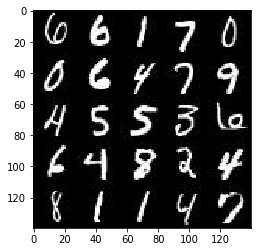

In [232]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

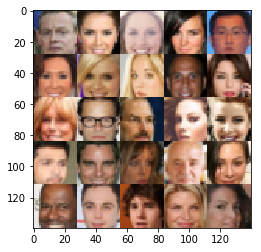

In [233]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [234]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [235]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    learning_rate =  tf.placeholder(tf.float32,(None),name='learning_rate')

    return (real_input,z_input,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [254]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        x1 = tf.layers.batch_normalization(x1,training=True)
        x1 = tf.maximum(0.2*x1,x1)
        x2 = tf.layers.conv2d(x1,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(0.2*x2,x2)
        x3 = tf.layers.conv2d(x2,256,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.maximum(0.2*x3,x3)
        x4 = tf.layers.conv2d(x3,512,5,strides=2,padding='same')
        x4 = tf.layers.batch_normalization(x4,training=True)
        x4 = tf.maximum(0.2*x4,x4)
        flat = tf.reshape(x4,(-1,4*4*512))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return (out, logits)  
    
    
    
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,4,strides=2,padding='same')
        x1 = tf.layers.batch_normalization(x1,training=True)
        x1 = tf.maximum(0.2*x1,x1)
        x2 = tf.layers.conv2d(x1,128,4,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(0.2*x2,x2)
        x3 = tf.layers.conv2d(x2,256,4,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.maximum(0.2*x3,x3)
        flat = tf.reshape(x3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [258]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    """
    reuse = not is_train
    with tf.variable_scope('generator',reuse=reuse):
        x1 = tf.layers.dense(z,4*4*448)
        x1 = tf.reshape(x1,(-1,4,4,448))
        x = tf.layers.conv2d_transpose(x1,448,2,strides=1,padding='same')
        x = tf.layers.batch_normalization(x,training=reuse)
        x = tf.maximum(0.2*x,x)
        x = tf.layers.conv2d_transpose(x,224,2,strides=1,padding='same')
        x = tf.layers.batch_normalization(x,training=reuse)
        x = tf.maximum(0.2*x,x)
        x2 = tf.layers.conv2d_transpose(x,112,4,strides=1,padding='valid')
        x2 = tf.layers.batch_normalization(x2,training=reuse)
        x2 = tf.maximum(0.2*x2,x2)
        x3 = tf.layers.conv2d_transpose(x2,56,2,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=reuse)
        x3 = tf.maximum(0.2*x3,x3)
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    return out
    """

    # TODO: Implement Function
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1,4,4,512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding="same")
        logits = x
        out = tf.tanh(logits)
    return out









"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [259]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim,True)
    d_model_real, d_model_logits = discriminator(input_real,False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_logits,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [260]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [261]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [262]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
asd = mnist_dataset.shape
adf = mnist_dataset.get_batches

In [263]:
imag3e = adf(300)

In [264]:
for image in imag3e:
    print(image.shape) 
    break

(300, 28, 28, 1)


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [265]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    data_mode = data_image_mode
    real_input,z_input,learning_rate_real = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, image_channels )
    
    learning_rate_real = learning_rate
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss,learning_rate_real, beta1)
    
    steps = 0
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                #recaling the images
                z_noiseinput = np.random.uniform(-1,1,size=(batch_size,z_dim))
                _ = sess.run(d_train_opt, feed_dict={real_input:batch_images, z_input:z_noiseinput})
                _ = sess.run(g_train_opt, feed_dict={z_input:z_noiseinput,real_input:batch_images})
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({z_input:z_noiseinput,real_input:batch_images})
                    train_loss_g = g_loss.eval({z_input:z_noiseinput})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 400 == 0:
                       show_generator_output(sess, 25, z_input,image_channels,data_mode)
                    

        
         
        
                

Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 3.0297
Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 1.7770
Epoch 2/2... Discriminator Loss: 0.1605... Generator Loss: 2.6212
Epoch 2/2... Discriminator Loss: 3.1474... Generator Loss: 0.0803


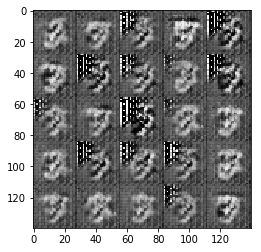

In [268]:
batch_size = 300
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 0.2008... Generator Loss: 2.3428
Epoch 1/10... Discriminator Loss: 0.7555... Generator Loss: 0.9109
Epoch 1/10... Discriminator Loss: 2.7681... Generator Loss: 8.0547
Epoch 1/10... Discriminator Loss: 2.8820... Generator Loss: 0.1872


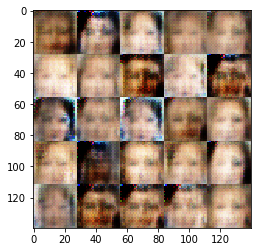

Epoch 1/10... Discriminator Loss: 2.0690... Generator Loss: 4.4274
Epoch 1/10... Discriminator Loss: 0.7588... Generator Loss: 0.9296
Epoch 1/10... Discriminator Loss: 0.5340... Generator Loss: 3.0765
Epoch 1/10... Discriminator Loss: 0.1639... Generator Loss: 4.1043


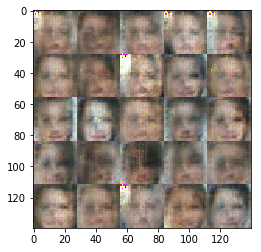

Epoch 1/10... Discriminator Loss: 0.5830... Generator Loss: 4.0158
Epoch 1/10... Discriminator Loss: 0.6709... Generator Loss: 1.0384
Epoch 1/10... Discriminator Loss: 1.6502... Generator Loss: 0.2683
Epoch 1/10... Discriminator Loss: 0.2797... Generator Loss: 2.3979


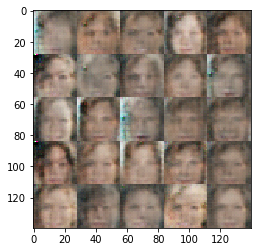

Epoch 1/10... Discriminator Loss: 0.6618... Generator Loss: 1.7614
Epoch 1/10... Discriminator Loss: 1.5836... Generator Loss: 0.4880
Epoch 1/10... Discriminator Loss: 1.2273... Generator Loss: 0.6791
Epoch 2/10... Discriminator Loss: 1.2464... Generator Loss: 0.8118


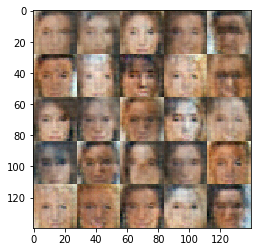

Epoch 2/10... Discriminator Loss: 1.0633... Generator Loss: 0.8611
Epoch 2/10... Discriminator Loss: 1.3550... Generator Loss: 0.4940
Epoch 2/10... Discriminator Loss: 0.9049... Generator Loss: 1.0938
Epoch 2/10... Discriminator Loss: 0.9222... Generator Loss: 1.2575


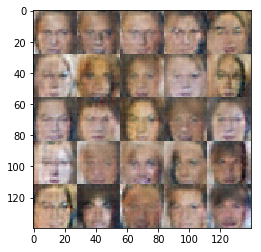

Epoch 2/10... Discriminator Loss: 1.5942... Generator Loss: 0.2996
Epoch 2/10... Discriminator Loss: 1.0196... Generator Loss: 0.8551
Epoch 2/10... Discriminator Loss: 2.1178... Generator Loss: 0.1805
Epoch 2/10... Discriminator Loss: 1.1217... Generator Loss: 0.8787


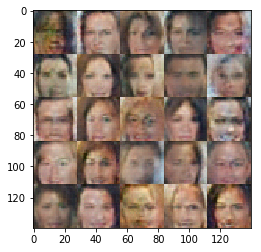

Epoch 2/10... Discriminator Loss: 1.2625... Generator Loss: 0.4717
Epoch 2/10... Discriminator Loss: 0.9078... Generator Loss: 1.2634
Epoch 2/10... Discriminator Loss: 0.9186... Generator Loss: 1.3014
Epoch 2/10... Discriminator Loss: 1.7403... Generator Loss: 0.3111


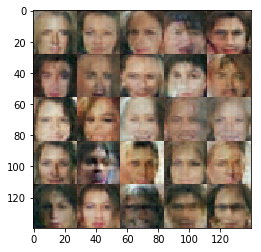

Epoch 2/10... Discriminator Loss: 1.4022... Generator Loss: 0.4483
Epoch 2/10... Discriminator Loss: 1.1683... Generator Loss: 1.4796
Epoch 2/10... Discriminator Loss: 0.8563... Generator Loss: 1.4969
Epoch 3/10... Discriminator Loss: 1.1477... Generator Loss: 1.1757


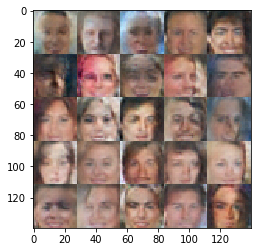

Epoch 3/10... Discriminator Loss: 1.0416... Generator Loss: 0.7441
Epoch 3/10... Discriminator Loss: 1.7923... Generator Loss: 0.2558
Epoch 3/10... Discriminator Loss: 1.0563... Generator Loss: 0.5614
Epoch 3/10... Discriminator Loss: 1.5888... Generator Loss: 0.7974


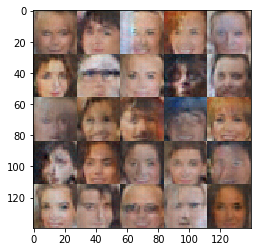

Epoch 3/10... Discriminator Loss: 1.0725... Generator Loss: 1.4132
Epoch 3/10... Discriminator Loss: 0.9636... Generator Loss: 0.6867
Epoch 3/10... Discriminator Loss: 1.2794... Generator Loss: 0.8647
Epoch 3/10... Discriminator Loss: 1.1813... Generator Loss: 0.8197


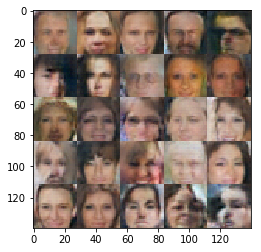

Epoch 3/10... Discriminator Loss: 1.1747... Generator Loss: 0.7874
Epoch 3/10... Discriminator Loss: 0.9159... Generator Loss: 0.7679
Epoch 3/10... Discriminator Loss: 1.1768... Generator Loss: 0.7417
Epoch 3/10... Discriminator Loss: 1.3113... Generator Loss: 0.6456


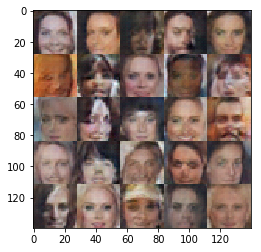

Epoch 3/10... Discriminator Loss: 1.3225... Generator Loss: 2.0548
Epoch 3/10... Discriminator Loss: 1.1599... Generator Loss: 0.7652
Epoch 3/10... Discriminator Loss: 1.2416... Generator Loss: 1.1083
Epoch 4/10... Discriminator Loss: 0.3985... Generator Loss: 2.4700


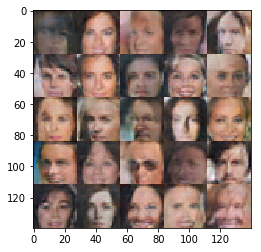

Epoch 4/10... Discriminator Loss: 1.2237... Generator Loss: 0.6435
Epoch 4/10... Discriminator Loss: 1.5268... Generator Loss: 1.9144
Epoch 4/10... Discriminator Loss: 0.8618... Generator Loss: 1.6199
Epoch 4/10... Discriminator Loss: 1.2314... Generator Loss: 1.0318


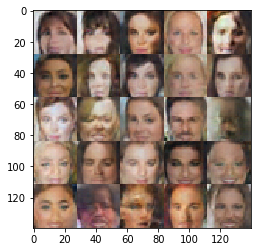

Epoch 4/10... Discriminator Loss: 1.3075... Generator Loss: 0.9240
Epoch 4/10... Discriminator Loss: 1.1990... Generator Loss: 0.8605
Epoch 4/10... Discriminator Loss: 0.9823... Generator Loss: 1.2379
Epoch 4/10... Discriminator Loss: 1.3196... Generator Loss: 1.0597


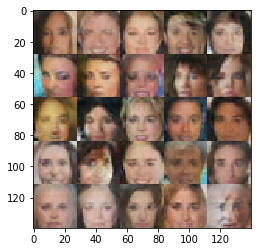

Epoch 4/10... Discriminator Loss: 1.2944... Generator Loss: 0.6955
Epoch 4/10... Discriminator Loss: 1.2916... Generator Loss: 1.5343
Epoch 4/10... Discriminator Loss: 1.3393... Generator Loss: 0.5670
Epoch 4/10... Discriminator Loss: 1.2908... Generator Loss: 0.7985


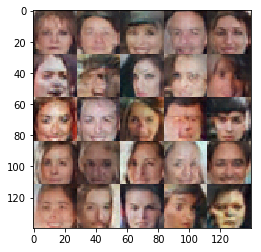

Epoch 4/10... Discriminator Loss: 1.3478... Generator Loss: 0.9928
Epoch 4/10... Discriminator Loss: 1.3739... Generator Loss: 0.5434
Epoch 4/10... Discriminator Loss: 1.6491... Generator Loss: 1.2309
Epoch 5/10... Discriminator Loss: 1.4366... Generator Loss: 0.4050


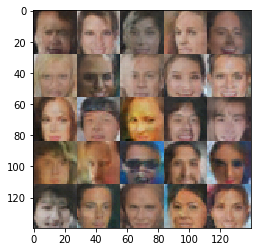

Epoch 5/10... Discriminator Loss: 0.5527... Generator Loss: 1.4455
Epoch 5/10... Discriminator Loss: 1.3113... Generator Loss: 2.5357
Epoch 5/10... Discriminator Loss: 1.0743... Generator Loss: 1.0507
Epoch 5/10... Discriminator Loss: 1.5316... Generator Loss: 0.2956


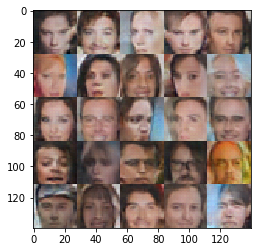

Epoch 5/10... Discriminator Loss: 1.3620... Generator Loss: 1.0158
Epoch 5/10... Discriminator Loss: 1.3247... Generator Loss: 0.6519
Epoch 5/10... Discriminator Loss: 1.4037... Generator Loss: 0.5871
Epoch 5/10... Discriminator Loss: 1.3377... Generator Loss: 1.2333


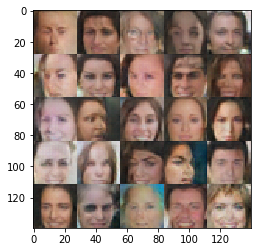

Epoch 5/10... Discriminator Loss: 1.3519... Generator Loss: 0.5204
Epoch 5/10... Discriminator Loss: 1.0300... Generator Loss: 0.8092
Epoch 5/10... Discriminator Loss: 1.3551... Generator Loss: 0.4982
Epoch 5/10... Discriminator Loss: 0.6507... Generator Loss: 0.9990


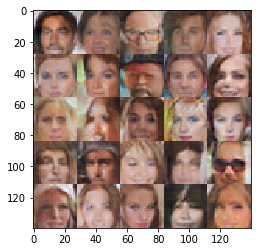

Epoch 5/10... Discriminator Loss: 1.2011... Generator Loss: 0.7906
Epoch 5/10... Discriminator Loss: 1.2624... Generator Loss: 0.7926
Epoch 5/10... Discriminator Loss: 1.6974... Generator Loss: 0.3216
Epoch 6/10... Discriminator Loss: 1.4221... Generator Loss: 0.4408


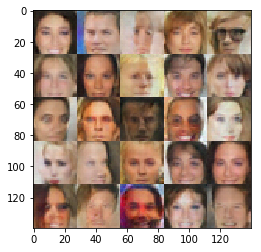

Epoch 6/10... Discriminator Loss: 1.0903... Generator Loss: 1.1543
Epoch 6/10... Discriminator Loss: 1.1936... Generator Loss: 1.2044
Epoch 6/10... Discriminator Loss: 1.9500... Generator Loss: 3.0158
Epoch 6/10... Discriminator Loss: 1.1547... Generator Loss: 0.5134


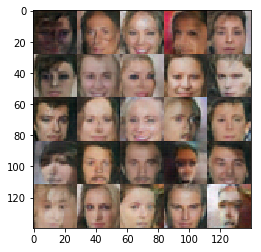

Epoch 6/10... Discriminator Loss: 1.3936... Generator Loss: 0.4271
Epoch 6/10... Discriminator Loss: 1.3216... Generator Loss: 0.5007
Epoch 6/10... Discriminator Loss: 1.4883... Generator Loss: 0.4624
Epoch 6/10... Discriminator Loss: 1.1662... Generator Loss: 0.8287


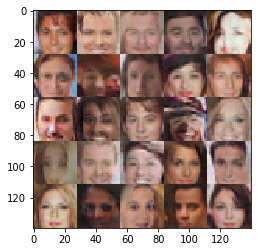

Epoch 6/10... Discriminator Loss: 1.3032... Generator Loss: 1.3484
Epoch 6/10... Discriminator Loss: 1.4169... Generator Loss: 0.4690
Epoch 6/10... Discriminator Loss: 1.2224... Generator Loss: 0.6889
Epoch 6/10... Discriminator Loss: 1.5008... Generator Loss: 0.4837


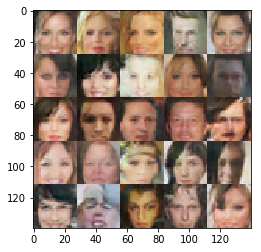

Epoch 6/10... Discriminator Loss: 1.1961... Generator Loss: 0.8619
Epoch 6/10... Discriminator Loss: 1.0303... Generator Loss: 0.8105
Epoch 7/10... Discriminator Loss: 1.2246... Generator Loss: 2.1622
Epoch 7/10... Discriminator Loss: 0.5826... Generator Loss: 1.0958


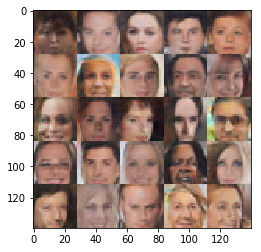

Epoch 7/10... Discriminator Loss: 0.9464... Generator Loss: 1.1356
Epoch 7/10... Discriminator Loss: 1.0166... Generator Loss: 0.7209
Epoch 7/10... Discriminator Loss: 1.3719... Generator Loss: 0.6578
Epoch 7/10... Discriminator Loss: 1.2284... Generator Loss: 0.5146


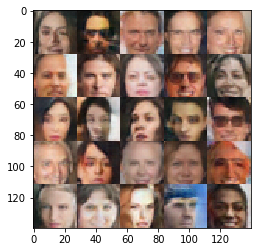

Epoch 7/10... Discriminator Loss: 1.1188... Generator Loss: 0.6520
Epoch 7/10... Discriminator Loss: 1.0625... Generator Loss: 0.8757


KeyboardInterrupt: 

In [267]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 8

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.